In [1]:
import csv
import os

In [8]:
# filtering; same as filter_silva_seqs.py
from Bio import SeqIO
# get full IDs
f_metadata = set('.'.join(i.strip().split('\t')[:3]) for h, i in enumerate(open('SILVA_138.2_SSURef_Nr99.full_metadata'))
                 if 'metagenome assembled genome' not in i.strip().split('\t')[10]
                 and 'partial sequence' not in i.strip().split('\t')[10])

seqs_before_filtering = 0
seqs_after_filtering = 0

f = 'SILVA_138.2_SSURef_NR99_tax_silva.fasta'
with open('SILVA_138.2_SSURef_NR99_tax_silva_filtered_strict.fasta','w') as out:
  for i in SeqIO.parse(f,'fasta'):
    seqs_before_filtering += 1
    id,d,s = str(i.id),str(i.description),str(i.seq).upper().replace('T','U')
    if id not in f_metadata: # filter out sequences not labeled as 16S rRNA in SILVA metadata
      continue
    elif 'eukaryota' in d.lower(): # filter out eukaryotic sequences e.g., 18S rRNA or mitochondria/plastid 16S rRNA
      continue
    elif set(s) != set('ACGU'): # filter out sequences with low quality base calls
      continue
    else:
      out.write(f'>{d}\n{s}\n')
      seqs_after_filtering += 1

print(f'Number of seqs before filtering: {seqs_before_filtering}')
print(f'Number of seqs after filtering: {seqs_after_filtering}')

Number of seqs before filtering: 510495
Number of seqs after filtering: 109695


In [2]:
# inspecting full metadata fields
with open('SILVA_138.2_SSURef_Nr99.full_metadata') as f:
    i = 0
    for line in f:
        if i == 0:
            head = line.strip().split('\t')
        else:
            body = line.strip().split('\t')
        i += 1
        if i > 500: break

for i in range(len(head)):
    print(i, head[i], body[i])

0 acc KJ143753
1 start 1
2 stop 1786
3 bio_material 
4 clone 
5 clone_lib 
6 collected_by 
7 collection_date 
8 culture_collection 
9 date 2014-03-31;2014-03-31
10 description Characium sp. UKM1 18S ribosomal RNA gene, partial sequence.
11 embl_class STD
12 embl_division PLN
13 env_sample 
14 flags 
15 gene 
16 haplotype 
17 identified_by 
18 insdc 
19 isolate UKM1
20 isolation_source waste water
21 lab_host 
22 lat_lon 
23 nuc_region 1..1786
24 pcr_primers 
25 plasmid_name 
26 product 18S ribosomal RNA
27 specimen_voucher 
28 strain 
29 sub_species 
30 version 1
31 depth_slv 
32 habitat_slv 
33 ambig_slv 0.00
34 ann_src_slv EMBL-EBI/ENA; RNAmmer;
35 homop_slv 0.45
36 homop_event_slv 7
37 pintail_slv 100.00
38 seq_quality_slv 92.52
39 vector_slv 0.00
40 align_bp_score_slv 106
41 align_cutoff_head_slv 3
42 align_cutoff_tail_slv 0
43 align_ident_slv 96.63
44 align_quality_slv 97.78
45 aligned_slv 2019-03-28 17:51:02
46 nuc_gene_slv 1783
47 clustered_slv 4
48 class_ident_slv 100
49 class_

In [ ]:
# filtering exploration
count_partial = 0
count_mag = 0
with open('SILVA_138.2_SSURef_Nr99.full_metadata') as f:
    i = 0
    for line in f:
        fields = line.strip().split('\t')
        if i == 0: 
            i += 1
            continue
        if int(fields[46]) < 1000: print(fields[10], fields[38], fields[44], fields[35])
        i += 1
        if 'metagenome genome assembly' in fields[10].lower():
            count_mag += 1
count_partial, count_mag

Odontotermes formosanus symbiont MOf1 gene for 16S rRNA, partial sequence. 95.00 99.52 0.30
Methanobacterium beijingense strain Md1 16S ribosomal RNA gene, partial sequence. 91.42 99.66 0.51
Ferroplasma acidiphilum strain BRGM4 16S ribosomal RNA gene, partial sequence. 91.11 97.44 0.53
Natrinema sp. IARI-WRS9 16S ribosomal RNA gene, partial sequence. 98.29 97.50 0.10
Uncultured archaeon clone G24 16S ribosomal RNA gene, partial sequence. 94.55 99.51 0.33
Uncultured archaeon clone TVG8AR02 16S ribosomal RNA gene, partial sequence. 94.52 97.71 0.33
Uncultured archaeon clone TVG8AR03 16S ribosomal RNA gene, partial sequence. 76.27 94.38 0.22
Uncultured archaeon clone TVG8AR12 16S ribosomal RNA gene, partial sequence. 94.70 90.24 0.32
Uncultured archaeon clone TVG8AR13 16S ribosomal RNA gene, partial sequence. 87.25 97.97 0.77
Uncultured archaeon clone TVG8AR14 16S ribosomal RNA gene, partial sequence. 87.25 97.75 0.77
Uncultured archaeon clone TVG8AR15 16S ribosomal RNA gene, partial sequ

(0, 8189)

In [2]:
# find handful of short lines, prove that each sequence contains at least 2 kmers
# (database contains exactly 408307 sequences, last output line is supposed to be blank)
#total_seqs = 397476
#total_seqs = 304727
total_seqs = 109695
fn = './results/s2k-14-110000.csv'
with open(fn, 'r') as f:
    for i, line in enumerate(f):
        if len(line) < 10: print(i, line, end='')
        if i == total_seqs: break

205 5
206 
215 
223 
753 9,10,11
1038 
1146 5,6,7,19
2121 0,1,2,35
2149 19,20,35
2177 2,5,6,7
2662 1,7
2672 1,7
2677 1,7
2678 
2682 1,7
2686 1
2695 1,7
2713 1,7
2733 1,7
2754 1,7
2797 
2798 
3809 35
3957 0,1
4025 35
4482 30,31,32
4491 
5005 
5362 6,7
5753 
5761 1,2,3,4
6106 
6158 
6416 35
6813 
6871 
7447 35
7913 4,5
8398 30,31,32
8399 30,31,32
9399 30,31,32
9404 30,31,32
9486 35
10281 0
10596 1,7
10823 1
11066 
11126 16,17,35
11433 10
11463 0,5,6,7
11520 0,5,6,7
11634 5,6,7,35
11651 5,6,7,16
11652 35
13876 5,6,7
14227 5,6,7
14249 5,6,7
15090 
15695 
15766 0,1
16347 0,1
16530 22,23,24
16665 1,7
16702 
16786 5,6,7
18569 5,6,7
18578 1,7
19652 18,25
20977 
21098 5,6,7
21201 
21945 16,17,18
21975 
22763 22,23,24
23236 16
23515 22,23,24
23940 22,23,24
24757 10,11,12
24938 5,6,35
25384 22,23,24
27843 1,2,3,4
27861 1,7
27891 0,5,6,7
28152 24,35
28451 1,7
29169 1,7
29172 5,6,7
29497 5,6,7
30452 1,7
30519 1,7
31647 1,7
31765 1
31777 5,6,7
31901 1
32416 1,7
33389 2
33431 0,1
33506 4
33621 1
3368

In [99]:
# get indices to drop after strict filtering
from Bio import SeqIO
idxs_to_drop = set()

f_metadata = set('.'.join(i.strip().split('\t')[:3]) for h, i in enumerate(open('SILVA_138.2_SSURef_Nr99.full_metadata'))
                 if 'metagenome assembled genome' not in i.strip().split('\t')[10]
                 and 'partial sequence' not in i.strip().split('\t')[10]
                 and h > 0
                 and float(i.strip().split('\t')[38]) > 90
                 and float(i.strip().split('\t')[44]) > 90)
"""
f_metadata = set(i.strip().split('\t')[1] for i in open('SILVA_138.2_SSURef_NR99.rnac', 'r')
                 if i.strip().split('\t')[5] == 'rRNA_16S'
                 and float(i.strip().split('\t')[8]) > 80
                 and float(i.strip().split('\t')[9]) > 80
                 and len(i.strip().split('\t')[-1]) > 1000)
"""
f = 'SILVA_138.2_SSURef_NR99_tax_silva_filtered_strict.fasta'
for idx, data in enumerate(SeqIO.parse(f,'fasta')):
    id = str(data.id) #'.'.join(str(data.id).split('.')[:2])
    if id not in f_metadata:
        idxs_to_drop.add(idx)

len(idxs_to_drop)

8518

In [102]:
# manually add things to drop
idxs_manual = [33506, 34343, 49653, 96346]
for i in idxs_manual:
    idxs_to_drop.add(i)
len(idxs_to_drop)

8522

In [103]:
# find kmer containment frequencies
from collections import Counter

c = Counter()
fn = './results/s2k-11-110000.csv'
with open(fn, 'r') as f:
    for i, line in enumerate(f):
        if i >= total_seqs : break
        if i in idxs_to_drop: continue
        count = min(len(line.strip()), len(line.strip().split(',')))
        c[count] += 1
        if count < 2: print(i, line.strip(), count)

c.most_common(5)

[(71, 24245), (56, 10114), (59, 6244), (53, 5104), (44, 4958)]

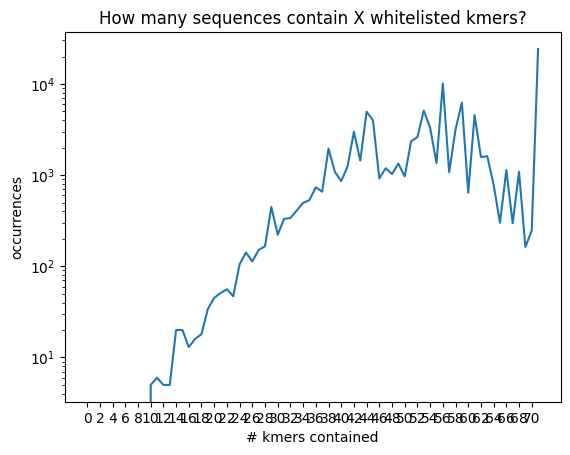

In [104]:
# plot
import matplotlib.pyplot as plt
import seaborn as sns

c_items = sorted(c.items(), key=lambda x: x[0])
ys = [0] * (c_items[-1][0] + 1)
for ci in c_items:
    ys[ci[0]] = ci[1]

sns.lineplot(ys)
plt.title('How many sequences contain X whitelisted kmers?')
plt.yscale('log')
plt.ylabel('occurrences')
plt.xlabel('# kmers contained')
plt.xticks(list(range(max(c.keys())+1)[::2]))
plt.show()

In [77]:
cmax = 10
count = 0
for i in range(cmax):
    count += c[i]
count

4

In [108]:
# get most frequent kmers
fn = './results/k-11-110000.csv'
hi_freq = []
best = (0, 0.0)
with open(fn, 'r') as f:
    for i, line in enumerate(f):
        freq = int(line.split(';')[1]) / total_seqs
        if freq > 0.96:
            print(i, '{:.4f}'.format(freq))
            hi_freq.append(i)
        if freq > best[1]:
            best = (i, freq)

len(hi_freq), best

5 0.9686
6 0.9754
7 0.9754
8 0.9686
9 0.9629
10 0.9616
18 0.9716
29 0.9723
30 0.9738
31 0.9779
32 0.9798
33 0.9788
34 0.9764
35 0.9775
36 0.9763
37 0.9781
38 0.9800
50 0.9669


(18, (38, 0.980008204567209))

In [110]:
# find all sequences containing best kmer and all that don't
fn = './results/s2k-11-110000.csv'
kmi = str(best[0])
contain = []
nocontain = []
with open(fn, 'r') as f:
    for i, line in enumerate(f):
        if i >= total_seqs: break
        if i in idxs_to_drop: continue
        if kmi in line: contain.append((i, line[:-1]))
        else: nocontain.append((i, line[:-1]))

len(nocontain)

1376

In [111]:
# greedy search to try to find minimum spanning kmers
spanning_kmers = [kmi]
nc = nocontain
while len(nc) != 0:
    count = Counter()
    for e in nc:
        for i in e[1].split(','):
            count[i] += 1
    best = count.most_common(1)[0][0]

    nc_next = []
    for e in nc:
        if best not in e[1].split(','):
            nc_next.append(e)
    nc = nc_next

    print(best, len(nc))
    spanning_kmers.append(best)

print(len(spanning_kmers), 'spanning kmers:', spanning_kmers)

50 127
2 13
18 2
11 0
5 spanning kmers: ['38', '50', '2', '18', '11']


In [112]:
# print actual kmers in order
fn = './results/k-11-110000.csv'
kms = []
with open(fn, 'r') as f:
    for line in f:
        kms.append(line.split(';')[0])
        
for ki in spanning_kmers:
    print(ki, '\t', kms[int(ki)])

38 	 (('A', 0), ('A', 1), ('U', 3), ('A', 6), ('A', 7), ('A', 11), ('U', 12), ('G', 14), ('C', 16), ('G', 17), ('G', 18))
50 	 (('U', 0), ('G', 1), ('A', 3), ('A', 4), ('G', 22), ('G', 23), ('A', 24), ('U', 26), ('G', 32), ('U', 33), ('A', 34))
2 	 (('A', 0), ('G', 2), ('G', 3), ('C', 11), ('A', 12), ('G', 13), ('G', 18), ('A', 20), ('U', 24), ('A', 45), ('A', 53))
18 	 (('A', 0), ('A', 6), ('U', 7), ('A', 9), ('G', 10), ('A', 11), ('C', 14), ('U', 20), ('A', 21), ('A', 34), ('U', 39))
11 	 (('C', 0), ('G', 5), ('C', 6), ('G', 8), ('A', 10), ('A', 11), ('C', 14), ('U', 43), ('G', 44), ('U', 49), ('G', 59))


In [114]:
# expand to keep minimum 2 kmers per sequence property
spanning_kmers_2 = ['38', '50']

fn = './results/s2k-11-110000.csv'
nc = []
with open(fn, 'r') as f:
    for i, line in enumerate(f):
        if i >= total_seqs: break
        if i in idxs_to_drop: continue
        if spanning_kmers_2[0] not in line or spanning_kmers_2[1] not in line:
            nc.append((i, line[:-1]))

# make sets for fast membership queries
nc = [(x,{int(z) for z in y.split(',')}) for x,y in nc]

print(len(nc))

in_order = [int(x) for x in spanning_kmers_2]
spanning_kmers_2 = set(in_order)

while len(nc) != 0:
    count = Counter()
    for e in nc:
        for i in e[1]:
            count[i] += 1
    best = count.most_common()

    for i in range(len(best)):
        if best[i][0] not in spanning_kmers_2:
            spanning_kmers_2.add(best[i][0])
            new = best[i][0]
            break

    nc_next = []
    for e in nc:
        inter = len(spanning_kmers_2.intersection(e[1]))
        if inter < 2:
            nc_next.append(e)
    nc = nc_next

    print(new, len(nc))
    in_order.append(new)

print(len(spanning_kmers_2), 'spanning kmers:', in_order)

3395
18 380
2 68
7 21
63 8
35 3
11 1
0 0
9 spanning kmers: [38, 50, 18, 2, 7, 63, 35, 11, 0]


[(5, 91452), (4, 7344), (3, 2072), (2, 276), (1, 29)]


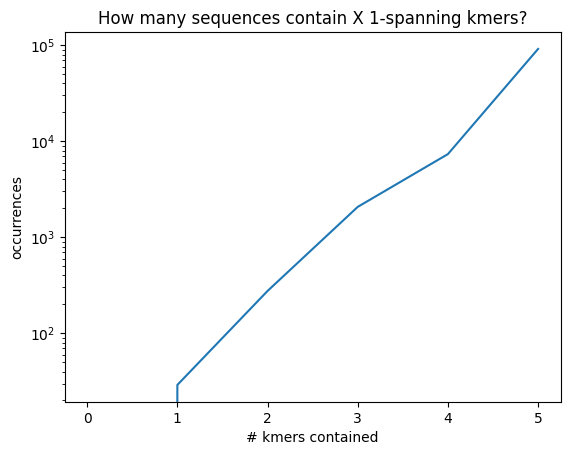

In [115]:
# how many seqs contain X 1-spanning kmers?
sk = set(spanning_kmers)

c = Counter()
fn = './results/s2k-11-110000.csv'
with open(fn, 'r') as f:
    for i, line in enumerate(f):
        if i >= total_seqs: break
        if i in idxs_to_drop: continue
        count = 0
        for k in line[:-1].split(','):
            if k in sk: count += 1
        c[count]  += 1

print(c.most_common(5))

c_items = sorted(c.items(), key=lambda x: x[0])
ys = [0] * (c_items[-1][0] + 1)
for ci in c_items:
    ys[ci[0]] = ci[1]

sns.lineplot(ys)
plt.title('How many sequences contain X 1-spanning kmers?')
plt.yscale('log')
plt.ylabel('occurrences')
plt.xlabel('# kmers contained')
plt.xticks(list(range(len(spanning_kmers)+1)))
plt.show()

[(9, 84056), (8, 9657), (7, 4758), (6, 1547), (5, 686)]


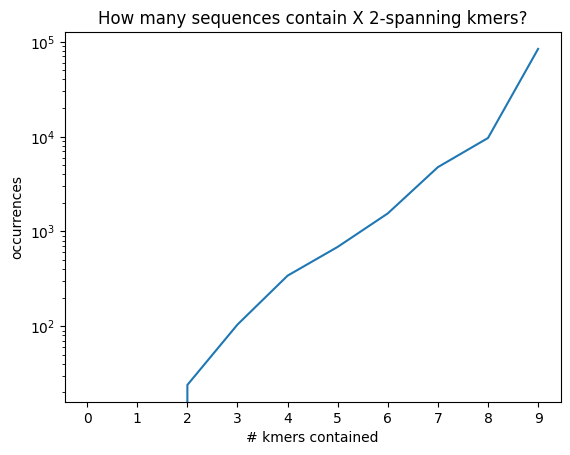

In [116]:
# how many contain X 2-spanning kmers?
sk = set(str(x) for x in in_order)

c = Counter()
fn = './results/s2k-11-110000.csv'
with open(fn, 'r') as f:
    for i, line in enumerate(f):
        if i >= total_seqs: break
        if i in idxs_to_drop: continue
        count = 0
        for k in line[:-1].split(','):
            if k in sk: count += 1
        c[count]  += 1

print(c.most_common(5))

c_items = sorted(c.items(), key=lambda x: x[0])
ys = [0] * (c_items[-1][0] + 1)
for ci in c_items:
    ys[ci[0]] = ci[1]

sns.lineplot(ys)
plt.title('How many sequences contain X 2-spanning kmers?')
plt.yscale('log')
plt.ylabel('occurrences')
plt.xlabel('# kmers contained')
plt.xticks(list(range(len(spanning_kmers_2)+1)))
plt.show()

In [117]:
# arbitrary N-spanning
N = 10
spanning_kmers_N = [str(x) for x in in_order[:N]] #[str(x) for x in hi_freq]

fn = './results/s2k-11-110000.csv'
nc = []
with open(fn, 'r') as f:
    for i, line in enumerate(f):
        if i >= total_seqs: break
        if i in idxs_to_drop: continue
        count = sum(x in line for x in spanning_kmers_N)
        if count < N:
            nc.append((i, line[:-1]))

# make sets for fast membership queries
nc = [(x,{int(z) for z in y.split(',')}) for x,y in nc]

print(len(nc))

in_order = [int(x) for x in spanning_kmers_N]
spanning_kmers_N = set(in_order)

while len(nc) != 0:
    count = Counter()
    for e in nc:
        for i in e[1]:
            count[i] += 1
    best = count.most_common()

    for i in range(len(best)):
        if best[i][0] not in spanning_kmers_N:
            spanning_kmers_N.add(best[i][0])
            new = best[i][0]
            break

    nc_next = []
    for e in nc:
        inter = len(spanning_kmers_N.intersection(e[1]))
        if inter < N:
            nc_next.append(e)
    nc = nc_next

    print(new, len(nc))
    in_order.append(new)

print(len(spanning_kmers_N), 'spanning kmers:', in_order)

101173
37 17117
32 7793
29 3833
4 2404
17 1720
14 1249
3 921
44 594
6 411
60 290
41 230
5 182
33 139
12 116
1 96
52 77
62 66
42 58
30 49
13 44
61 35
8 29
69 24
53 19
47 15
31 12
39 10
34 7
40 6
64 6
65 6
66 6
67 6
10 5
46 5
48 4
68 3
51 2
43 1
49 0
49 spanning kmers: [38, 50, 18, 2, 7, 63, 35, 11, 0, 37, 32, 29, 4, 17, 14, 3, 44, 6, 60, 41, 5, 33, 12, 1, 52, 62, 42, 30, 13, 61, 8, 69, 53, 47, 31, 39, 34, 40, 64, 65, 66, 67, 10, 46, 48, 68, 51, 43, 49]


In [45]:
# function definitions from Seth
import random
import numpy as np
import itertools
from Bio import SeqIO
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

def mutate_dna(dna_string, num_mutations):
    dna_list = list(dna_string)
    dna_length = len(dna_list)
    if num_mutations > dna_length:
        raise ValueError("Number of mutations cannot exceed the length of the DNA string.")

    mutation_indices = random.sample(range(dna_length), num_mutations)

    for index in mutation_indices:
        current_base = dna_list[index]
        valid_bases = ['A', 'U', 'C', 'G']
        if current_base not in valid_bases:
            continue
        else:
            valid_bases.remove(current_base) # Ensure the new base is different.
            new_base = random.choice(valid_bases)
            dna_list[index] = new_base

    return "".join(dna_list)  # Convert back to a string

def proportion_kmers_present(seq,kmers):
    present = 0
    for k in kmers:
        if k in seq:
            present += 1
    return present/len(kmers)

def get_kmers(seq,klen,total_possible_kmers,possible_kmers):
    kmer_counts = defaultdict(int)
    for i in range(0,len(seq)+1-klen):
        kmer = seq[i:i+klen]
        kmer_counts[kmer] += 1
    tmp = []
    tmp2 = []
    for k in possible_kmers:
        freq = kmer_counts.get(k,0)/total_possible_kmers
        tmp.append(str(freq))
        tmp2.append(freq)
    return '\t'.join(tmp),np.array(tmp2)

In [119]:
# get original kmers
from ast import literal_eval
fn = './results/k-11-110000.csv'
kms = dict()
with open(fn, 'r') as f:
    for i, line in enumerate(f):
        kms[i] = literal_eval(line.split(';')[0])
kms[0]

(('A', 0),
 ('U', 41),
 ('A', 62),
 ('G', 64),
 ('G', 65),
 ('C', 73),
 ('A', 74),
 ('G', 75),
 ('G', 80),
 ('A', 82),
 ('U', 86))

In [120]:
# modified random mutation detection
from utils.find_gapped import find_gapped

f = 'SILVA_138.2_SSURef_NR99_tax_silva_filtered_strict.fasta'
kmer_subset = in_order[:-13]
Decision_Boundary = 10
seq_max = 500

kmers = [kms[int(i)] for i in kmer_subset]

kmer_chars = np.array([[x[0] for x in kmer] for kmer in kmers])
kmer_offs = np.array([[x[1] for x in kmer] for kmer in kmers])

print("Decision_Boundary Total_seqs Proportion_seq_mutate TP TN FP FN")

for proportion_seq_mutate in [1.0,0.8,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01]:
    seqs = 0
    TP,TN,FP,FN = 0,0,0,0
    
    for h,i in enumerate(SeqIO.parse(f,'fasta')):
        if h in idxs_to_drop: continue
        id,d,s,L = str(i.id),str(i.description),str(i.seq).upper().replace('T','U'),len(i.seq)
        if 'eukaryota' in d.lower(): continue
        seqs += 1
        Counts = Counter(s)
        weights = [Counts['A']/L,Counts['C']/L,Counts['G']/L,Counts['U']/L]
        if proportion_seq_mutate == 1.0:
            random_seq = list(s).copy()
            random.shuffle(random_seq)
            random_seq = ''.join(random_seq)
        else:
            random_seq = mutate_dna(s, int(proportion_seq_mutate*L))
        present_s = np.sum(find_gapped(s, kmer_chars, kmer_offs))
        present_random = np.sum(find_gapped(random_seq, kmer_chars, kmer_offs))
        # print(total_seqs,end='\r') # progress tracker
        if present_s >= Decision_Boundary: # True positive
            TP += 1
        elif present_s < Decision_Boundary: # False negative
            FN += 1
        if present_random >= Decision_Boundary: # False positive
            FP += 1
        elif present_random < Decision_Boundary: # True negative
            TN += 1
        if seqs == seq_max:
            break
    
    print(Decision_Boundary,seqs,proportion_seq_mutate,TP,TN,FP,FN)

Decision_Boundary Total_seqs Proportion_seq_mutate TP TN FP FN
10 500 1.0 500 500 0 0
10 500 0.8 500 500 0 0
10 500 0.6 500 500 0 0
10 500 0.5 500 500 0 0
10 500 0.4 500 500 0 0
10 500 0.3 500 500 0 0
10 500 0.2 500 477 23 0
10 500 0.1 500 224 276 0
10 500 0.05 500 27 473 0
10 500 0.01 500 0 500 0


In [87]:
# find sequences with low kmer counts
j = 0
tgt_count = 10
tgt_seqs = []
fn = './results/s2k-11-110000.csv'
with open(fn, 'r') as f:
    for i, line in enumerate(f):
        if i >= total_seqs: break
        if i in idxs_to_drop: continue
        count = len(line.split(','))
        if count < tgt_count and j < 50:
            tgt_seqs.append(i)
            j += 1

print(len(tgt_seqs), tgt_seqs)

4 [33506, 34343, 49653, 96346]


In [55]:
# manual tgt_seqs override
tgt_seqs = [163071, 186795, 241684]

In [80]:
# sequences containing very few kmers
from utils.find_gapped import find_gapped

# find seqs with specific taxons
f = 'SILVA_138.2_SSURef_NR99_tax_silva_filtered.fasta'
small_seqs = []
for h,i in enumerate(SeqIO.parse(f,'fasta')):
    id,d,s,L = str(i.id),str(i.description),str(i.seq).upper().replace('T','U'),len(i.seq)
    if h in tgt_seqs:
        print('\t'.join([id, d, str(L)]))
    if 'Picea glauca' in d.split(' ', 1)[1].split(';')[-1]:
        small_seqs.append(s)

print(len(small_seqs), 'taxons found')

# check membership
"""
kmer_subset = list(range(94))
kmers = [kms[int(i)] for i in kmer_subset]
kmer_chars = np.array([[x[0] for x in kmer] for kmer in kmers])
kmer_offs = np.array([[x[1] for x in kmer] for kmer in kmers])

memberships = []
for i, s in enumerate(small_seqs):
    memberships.append(np.sum(find_gapped(s, kmer_chars, kmer_offs)))
    if i > 10: break"""
print('done')

AJ233938.1.1534	AJ233938.1.1534 Bacteria;Myxococcota;Polyangiia;Polyangiales;Polyangiaceae;Chondromyces;Chondromyces apiculatus	1534
KJ781405.1.1404	KJ781405.1.1404 Bacteria;Pseudomonadota;Gammaproteobacteria;Enterobacterales;Enterobacteriaceae;Enterobacter;Enterobacter cloacae	1404
AB048213.1.1439	AB048213.1.1439 Bacteria;Actinomycetota;Actinobacteria;Micromonosporales;Micromonosporaceae;Actinoplanes;Actinoplanes digitatis	1439
AB369019.1.1359	AB369019.1.1359 Bacteria;Pseudomonadota;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;Acinetobacter;uncultured bacterium	1359
JQ188781.1.1372	JQ188781.1.1372 Bacteria;Bacillota;Clostridia;Oscillospirales;[Eubacterium] coprostanoligenes group;Incertae Sedis;uncultured bacterium	1372
KM495868.1.1496	KM495868.1.1496 Bacteria;Bacillota;Bacilli;Lactobacillales;Lactobacillaceae;Lactiplantibacillus;Lactobacillus plantarum	1496
LN567256.1.1311	LN567256.1.1311 Bacteria;Pseudomonadota;Alphaproteobacteria;Hyphomicrobiales;Xanthobacteraceae;Pseudolabrys

Text(0.5, 1.0, 'Membership across taxon')

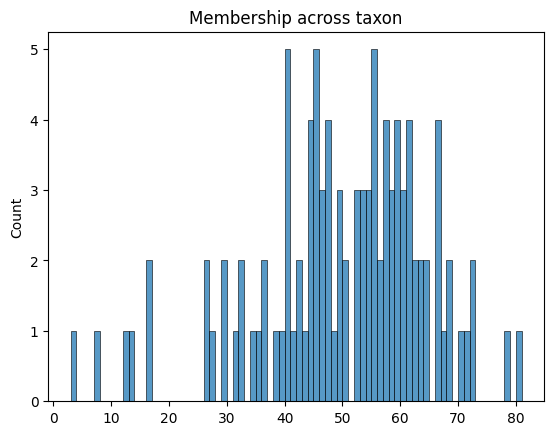

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(memberships, binwidth=1)
plt.title('Membership across taxon')

In [88]:
# does RC fix it? apparently not
def revcomp(seq):
    revcomp = ''
    for i in seq[::-1]:
        revcomp += {'A':'U','C':'G','G':'C','U':'A'}.get(i,i)
    return revcomp

kmer_subset = list(range(len(kms.keys())))
kmers = [kms[int(i)] for i in kmer_subset]
kmer_chars = np.array([[x[0] for x in kmer] for kmer in kmers])
kmer_offs = np.array([[x[1] for x in kmer] for kmer in kmers])

ids = []
f = 'SILVA_138.2_SSURef_NR99_tax_silva_filtered_strict.fasta'
for h,i in enumerate(SeqIO.parse(f,'fasta')):
    if h in tgt_seqs:
        id,d,s,L = str(i.id),str(i.description),str(i.seq).upper().replace('T','U'),len(i.seq)
        print(id, np.sum(find_gapped(s, kmer_chars, kmer_offs)))
        ids.append(id)


JSAD01000350.6376.7802 8
HE589734.1.901 5
FN691486.1.916 7
FAOM01019013.54873.56799 9


In [84]:
# get metadata
f_metadata = [i.strip().split('\t') for i in open('SILVA_138.2_SSURef_NR99.rnac') if i.strip().split('\t')[5] == 'rRNA_16S']

In [89]:
# inspect specific sequences
mdids = [f_metadata[i][0] for i in range(len(f_metadata))]

ids_shortened = [e.split('.')[0] for e in ids]
for i in range(len(mdids)):
    if mdids[i] in ids_shortened:
        print(len(f_metadata[i][-1]), f_metadata[i])

1427 ['JSAD01000350', 'JSAD01000350.1', '6376..7802', '0', '0', 'rRNA_16S', 'ECO:0000080', 'phylogenetic evidence', '96.5', '90.57', 'Ref NR', '3702', '', 'Bacteria;Cyanobacteriota;Cyanobacteriia;Chloroplast;Incertae Sedis;Incertae Sedis;', 'https://www.arb-silva.de/browser/ssu/JSAD01000350', 'AGAGUUCGAUCCUGGCUCAGGAUGAACGCUGGCGGCAUGCUUAACACAUGCAAGUCGGACGGGAAGUGGUGUUUCCAGUGGCGGACGGGUGAGUAACGCGUAAGAACCUGCCUUGGAGGGAACAACAGCUGGAAACGGCUGCUAAUACCCGUAGGCUGAGGAGCAAAAGGAGGAAUCCGCCGAGGAGGGCUCGCGUCUGAUUAGCUAGUUGGUGAGGCAAUAGCUUACCAAGGCGAUGAUCAGUAGCUGGUCCGAGAGGAUGAUCAGCCACACUGGACUGAGACACGGCCAGACUCCUACGGGAGGCAGCAGUGGGGAAUUUUCCGCAAUGGGCGAAAGCCUGACGGAGCAAUGCCGCGUGGAGGUAGAAGGCCUACGGUCCUGAACUUCUUUUCCCAGAGAAGAAGCAAUGACGGUAUCUGGGGAAUAAGCAUCGGCUAACUCUGUGCAGCAGCCGCGGUAAUACAGAGGAUGCAAGCGUUAUCCGGAAUGAUUGGGCGUAAAGCGUCUGUAGGUGGCUUUUUAAGUCCGCCGUCAAAUCCAGGGCUCAACCCUGGACAGGCGGUGGAAACUACCAAGCUUGAGUACGGUAGGGCAGAGGGAAUUUCCGGUGGAGCGUGAAAUGCGUAGAGAUCGGAAAGAACACCAACGGCGAAAGCACUCUGCUGGCCGACACUGACACUGAGAGACGAAAGCUAGGGAGCG